<a href="https://colab.research.google.com/github/Denzel18/Progetto_CV_DL_P/blob/gh-pages/ALEX_%26_DENIS_AGGIORNATO_3_Data_Generation_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA GENERATION 

### IMPORT

In [62]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U opencv-python".split())
  #subprocess.call("pip install tensorflow==2.0.*".split())
  #subprocess.call("pip install keras==2.3.1".split())
  
#TensorFlow 2.0 and Keras 2.3.1 frameworks   

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

from tensorflow.keras.models import Sequence




from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 30 )

print(tf.__version__)


ImportError: ignored

### DRIVE 

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)
#from functions import preprocessing 
#from functions import split_data 
#from functions import plot_confusion_matrix
#from functions import BalancedDataGenerator

Mounted at /content/drive


### DATA GENERATION 

In [3]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(270, 470),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        #print( self.n_CLASSE_CALCIO)
    
    #per modificare il dataset tra le esecuzioni di diverse epoche (QUINDI FORSE NON SERVE)
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    #la funzione ritornerà un vettore Numpy di forma [target_height, target_width, 3]
    def __get_input(self, path, target_size):
      try:
        first_char = path[0]
        if first_char != 'm':
          image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CALCIO_CROP/'+path)
        else: 
          image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/MASK_CALCIO_CROP/'+path)
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      #resize dell'immagine secondo le dimensioni volute di 270*470       
      image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
      return image_arr/255.     #perchè di base è tra [0 255] invece deve tornare un valore tra 0 e 1 
    
    #prende come parametri i valori e il numero di classi e ritorna un vettore Numpy di forma [num_classes,]
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['PATH_IMG']]  
      
        CLASSE_batch = batches[self.y_col['CLASSE']]
        #print('{} - {}'.format(path_batch,CLASSE_batch))

        #FORSE QUA SONO LEGGERMENTE DA MODIFICARE
        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

        y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        
        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y                                     #X rappresenta l'input, y rappresenta l'output
    
    def __len__(self):
        return int(self.n) // self.batch_size


## Maschere


In [4]:
def mask(path):
        ######## MASK ############  ---> IN UNA NUOVA COLONNA DEL DATAFRAME RESULT 
        img = cv2.imread("/content/drive/MyDrive/CALCIO_CROP/"+path, cv2.IMREAD_GRAYSCALE)
        _, threshold = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        #for cnt in contours:
        #    cv2.drawContours(img, [cnt], 0, (0))
        cv2.imwrite("/content/drive/MyDrive/MASK_CALCIO_CROP/mask_"+path, threshold)

## Immagini 

In [5]:

os.chdir('/content/drive/MyDrive/ProgettoDL/')
#from functions import preprocessing, split_data, plot_confusion_matrix, BalancedDataGenerator
# ----------------------#-----IMMAGINI----#----------------------# 
random_state = 3

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#lettura dataset annotazioni
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

if 'gray' in tipo:
  colormode = "grayscale"
  print('analisi in scala di grigi')
else:
  colormode = "rgb"

In [6]:
'''NETWORK'''

model = Sequential()
vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

# build top model         
x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='predictions')(x)
# stitch together
model = Model(inputs= vgg16_conv.input, outputs=x)


# inspect
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 270, 470, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 470, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 470, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 235, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 235, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 235, 128)     147584    
______________________________________________________________

In [7]:
'''CALLBACKS'''
#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
model_checkpoint = ModelCheckpoint( filepath=os.path.join(path+'weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

### MODIFICATO QUA - Implementazione Early Stopping###
#tf.keras.callbacks.EarlyStopping(patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #Quantity to be monitored
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False,
)


callbacks=[model_checkpoint , early_stopping]

In [8]:
#Definizione hyperparameters

opt = Adam(learning_rate=0.0001)
#opt = SGD(lr=0.0001, decay=1e-5, momentum=0.9)

loss='categorical_crossentropy'
num_epochs = 1 #era 50
bs = 8 #era 8 

model.compile(loss=loss, optimizer=opt, metrics = ['accuracy']) 

## SPLIT DATA

In [9]:
#-------------------------------------------------------------------------------------------------------------------------------divisione dei dati
def split_data(dataframe_result, val_size, test_size, random_state):
#data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
#label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
#val_size = 0.2 scelta nel codice
#test_size = 0.2 scelta nel codice
#random_state = 3 (parametro impostato nel codice)

  #unique_result = dataframe_result.nunique(axis=1) #ID - Colonna 0
  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)
  #print('Counts')
  #print(counts)
  #print('Sto stampando...')
  #print(unique_result)
  
  
  
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))
  test_size = int(test_size*len(id_perm))   
  #print('Test Size : {}'.format(test_size))                            
  val_size = int(val_size*len(id_perm))   
  #print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
                    

  #definisco i dataframe finali 
  column_names = ['ID','filename', 'class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
  for i in test_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_test=x_test.append(row_1, ignore_index=True) 
    x_test=x_test.append(row_2, ignore_index=True)
  
  for i in val_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_val=x_val.append(row_1, ignore_index=True) 
    x_val=x_val.append(row_2, ignore_index=True)
  
  for i in train_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_train=x_train.append(row_1, ignore_index=True) 
    x_train=x_train.append(row_2, ignore_index=True)
    
  return x_train, x_test, x_val




## PREPROCESSING & DATA FRAME 

In [24]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID","IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx.columns = ['ID','filename', 'class']
dataframe_dx.columns = ['ID','filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx, dataframe_dx]
result = pd.concat(frames)
print(result)
print(result.loc[[1]])
print(type(result.loc[[1]]))

print("Lunghezza DataFrame complessivo : {} ".format(result[result.columns[0]].count()))

#MAPPING 
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
#result["class"] = result["class"].map({'1': 0, '2-': 1, '2': 2, '2+': 3, '3-': 4, '3': 5 ,'3+': 6, '4-': 7, '4': 8, '4+': 9})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result['class'].isnull().sum()))
print(result.loc[result['class'] == '0'])
print(result[result['class'].isnull()])
result['class'] = pd.to_numeric(result['class'], errors='coerce')
print(result[result['class'].isnull()])
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result[result['class'].isnull()])

print("Null VALUE di class : "+format(result['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_CROP')
for index, row in result.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
    #else:
    #  mask(filename)                                                            #QUESTA RIGA SALVA IN MEMORIA TUTTE LE MASCHERE QUINDI COMMENTALA SE GIA' USATA (PERCHE' IMPIEGA MOLTO TEMPO)                   


#----------------------------------------------------------------inserisco nel dataframe una nuova colonna, con le immagini trasformate in array----------------------------------
# dsize
immg_rows = 270 
immg_cols = 470
dim = (immg_rows, immg_cols)


mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])
    

#CARICO LE IMMAGINI E LE TRASFORMO IN ARRAY
#    try:                                                                    # provo ad aprire l'immagine, altrimenti dico a video che non l'ho trovata    
#        image = load_img("/content/drive/MyDrive/MASK_CALCIO_CROP/mask_"+filename)
#
#    except Exception:
#        print('{}_not found'.format(filename))
#        continue
#    imgs_array = []
#    x = img_to_array(image)
#    x = np.asarray(np.dstack((x, x, x)), dtype=np.uint8)
#    imgs_array.append(x) 
   
   
print(mask_filenames)

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME CON MASCHERE")
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename',
  axis='columns', inplace=True)

column_names = ["ID", "mask_filename", "class"]

result2 = result2.reindex(columns=column_names)
print(result2)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")


train, test, validation  = split_data(result, 0.2, 0.2, 3)
train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)

os.chdir('/content/drive/MyDrive/ProgettoDL')
train.to_csv("train_1.csv")
test.to_csv("test_1.csv")
validation.to_csv("validation_1.csv")


print("Lunghezza DataFrame complessivo : {}".format(result[result.columns[0]].count()))
print("Lunghezza Train : "+format(len(train)))
print("Lunghezza Test : "+format(len(test)))
print("Lunghezza Validation : "+format(len(validation)))

        ID            filename class
0        3  20201 319 5323.png    3+
1        4  20201 3110125 .png    3+
2        5  20201 31101327.png    3+
3        6  20201 3110161 .png    3+
4        7  20201 3110177 .png    3+
...    ...                 ...   ...
1059  2023  20201031090549.png    3+
1060  2024  20201031090855.png    3+
1061  2025  20201031091127.png    3+
1062  2026  20201031091720.png    3+
1063  2027  20201031091941.png    3+

[2128 rows x 3 columns]
   ID            filename class
1   4  20201 3110125 .png    3+
1   4  20201 31101226.png    3+
<class 'pandas.core.frame.DataFrame'>
Lunghezza DataFrame complessivo : 2128 
Null VALUE di class : 2
Empty DataFrame
Columns: [ID, filename, class]
Index: []
       ID            filename  class
963  1927  20200825181909.png    NaN
963  1927  20200825181932.png    NaN
       ID            filename  class
963  1927  20200825181909.png    NaN
963  1927  20200825181932.png    NaN
Empty DataFrame
Columns: [ID, filename, class]
Index: 

## TESTING MODEL

In [36]:
#Generators


traingen = CustomDataGen(train, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(validation, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))

#history = model.fit(traingen,validation_data=valgen, epochs=num_epochs, callbacks = callbacks)

print('------------------------------- FINE IMG - INIZIO MASK ------------------------------------------')

traingen_mask = CustomDataGen(train_mask, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen_mask = CustomDataGen(validation_mask, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))
#history_mask = model.fit(traingen_mask,validation_data=valgen_mask, epochs=num_epochs, callbacks = callbacks)

#history = model.fit(aug.flow(training_generator, y_train, batch_size= bs),  steps_per_epoch=len(training_generator) / bs,
#                     epochs=num_epochs, validation_data=(validation_generator, y_val), class_weight = weight, verbose=1, callbacks = callbacks)

------------------------------- FINE IMG - INIZIO MASK ------------------------------------------


## PLOT 

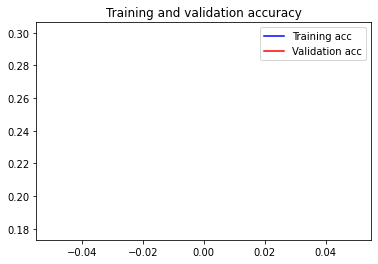

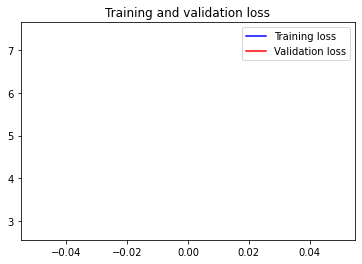

In [13]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lista = [acc,val_acc,loss,val_loss]


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

### SAVE MODEL 

In [69]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/Final/assets
Saved model to disk


## Parte da Rivedere - Non ultimata 

In [68]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)

path_model = os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn))


#path_model = os.path.join(path + 'weights/model_{}_{}/best_weights.h5'.format(immgs,cnn))
model = load_model(path_model)


In [103]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model


test_array = []

for index, row in test.iterrows():
    class_ = int(row['class'])
    test_array.append(class_)

test_array = np.array(test_array)
print(test_array)
print(type(test_array))
print(test_array.size)
y_test = test_array.argmax(axis=0)
y_pred = model.predict(traingen, steps=1)
y_pred_mask = model.predict(traingen_mask, steps=1, verbose=0, workers=1, use_multiprocessing=True)


print(y_pred)
print(type(y_pred))
print(y_pred.size)

#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred)

[7 8 6 6 8 8 5 5 8 8 3 1 2 2 5 6 8 7 6 6 3 2 0 0 0 0 0 1 6 6 8 8 7 7 5 6 4
 4 8 8 6 6 5 5 6 6 8 8 8 8 5 4 5 5 5 5 1 1 6 6 0 1 4 4 5 5 9 9 6 7 9 9 2 0
 5 5 1 1 1 3 4 4 6 6 4 5 8 7 4 4 2 2 2 2 6 6 1 1 5 5 2 2 1 1 8 8 9 9 2 5 2
 2 6 6 3 3 3 3 5 5 2 2 2 3 5 5 2 1 4 4 5 5 2 1 3 3 2 2 6 6 4 4 0 5 8 8 4 4
 3 3 1 1 7 8 9 9 5 0 3 3 1 2 7 7 0 2 6 6 0 0 8 8 8 8 6 6 7 7 1 1 1 1 6 6 3
 3 5 5 4 4 5 5 4 4 3 3 2 2 7 8 4 4 8 8 1 2 6 6 6 6 5 5 8 7 6 6 6 6 2 3 3 3
 1 2 6 5 3 4 6 6 3 3 9 9 0 0 6 6 3 3 3 3 4 4 0 0 8 8 7 8 7 7 4 3 3 3 5 5 0
 0 6 6 1 0 6 6 9 8 7 7 5 5 8 8 6 7 3 3 5 5 4 5 5 5 6 6 1 0 9 8 5 5 7 7 6 6
 6 7 1 1 0 0 6 6 7 7 8 6 5 5 9 9 2 2 2 2 7 9 2 3 0 0 9 9 2 2 6 6 2 2 7 7 0
 0 8 7 0 0 5 5 0 0 1 2 1 0 3 3 3 3 8 7 5 5 3 3 8 8 5 4 1 2 4 4 4 4 9 9 4 4
 5 5 2 2 3 3 6 6 0 0 1 1 4 4 6 5 4 4 8 8 8 8 4 4 1 1 5 5 2 2 7 7 8 8 2 2 6
 5 6 6 8 8 5 5 6 6 6 6 8 9 3 3 9 9]
<class 'numpy.ndarray'>
424
[[3.77443410e-09 5.53008306e-07 2.70000333e-03 3.12459383e-06
  2.92433164e-04 1.40578311e-04 1.71946045e-02 3.

In [125]:
'''METRICHE'''

#to_categorical ---- >????
#y_test = to_categorical(np.unique(y_test, return_inverse=True)[1])
print(test_array)

y_test_t = [0, 0, 1, 3,5,1,7,8,1]
y_true_t = [0, 2, 1, 3,5,6,7,8,2,2]
y_pred_t = [0, 1, 2, 3,5,6,7,8,1,1]
#percentage of correctly classified samples
a = accuracy_score(y_true_t, y_pred_t)
print("test accuracy:",)
#a = accuracy_score(y_test, y_pred, normalize=False)
print("test accuracy:",a)
print("precision:", precision_score(y_test_t, y_pred_t , average="macro"))
print("recall:", recall_score(y_test_t, y_pred_t , average="macro"))
print("f1_score:", f1_score(y_test_t, y_pred_t , average="macro"))

print('classification report:')
print(classification_report(y_test_t, y_pred_t))

[7 8 6 6 8 8 5 5 8 8 3 1 2 2 5 6 8 7 6 6 3 2 0 0 0 0 0 1 6 6 8 8 7 7 5 6 4
 4 8 8 6 6 5 5 6 6 8 8 8 8 5 4 5 5 5 5 1 1 6 6 0 1 4 4 5 5 9 9 6 7 9 9 2 0
 5 5 1 1 1 3 4 4 6 6 4 5 8 7 4 4 2 2 2 2 6 6 1 1 5 5 2 2 1 1 8 8 9 9 2 5 2
 2 6 6 3 3 3 3 5 5 2 2 2 3 5 5 2 1 4 4 5 5 2 1 3 3 2 2 6 6 4 4 0 5 8 8 4 4
 3 3 1 1 7 8 9 9 5 0 3 3 1 2 7 7 0 2 6 6 0 0 8 8 8 8 6 6 7 7 1 1 1 1 6 6 3
 3 5 5 4 4 5 5 4 4 3 3 2 2 7 8 4 4 8 8 1 2 6 6 6 6 5 5 8 7 6 6 6 6 2 3 3 3
 1 2 6 5 3 4 6 6 3 3 9 9 0 0 6 6 3 3 3 3 4 4 0 0 8 8 7 8 7 7 4 3 3 3 5 5 0
 0 6 6 1 0 6 6 9 8 7 7 5 5 8 8 6 7 3 3 5 5 4 5 5 5 6 6 1 0 9 8 5 5 7 7 6 6
 6 7 1 1 0 0 6 6 7 7 8 6 5 5 9 9 2 2 2 2 7 9 2 3 0 0 9 9 2 2 6 6 2 2 7 7 0
 0 8 7 0 0 5 5 0 0 1 2 1 0 3 3 3 3 8 7 5 5 3 3 8 8 5 4 1 2 4 4 4 4 9 9 4 4
 5 5 2 2 3 3 6 6 0 0 1 1 4 4 6 5 4 4 8 8 8 8 4 4 1 1 5 5 2 2 7 7 8 8 2 2 6
 5 6 6 8 8 5 5 6 6 6 6 8 9 3 3 9 9]
test accuracy:
test accuracy: 0.6


ValueError: ignored

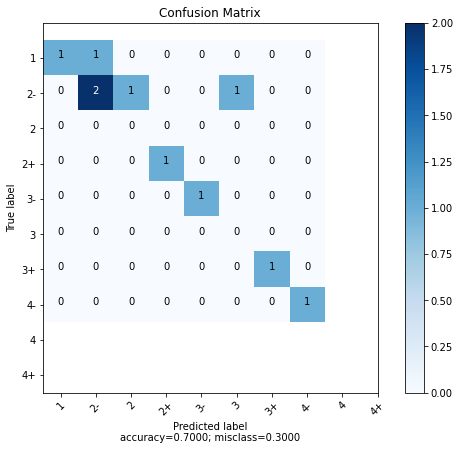

<Figure size 432x288 with 0 Axes>

In [124]:
#Confusion Matrix - CROP

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig


import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test_t, y_pred=y_pred_t)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 

In [121]:
#Confusion Matrix - MASK
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=test_mask['class'], y_pred=y_pred_mask)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 

ValueError: ignored